# Module 2: From Poisson Process to Real Workload Generator
## Practical Validation with M/M/1 Server

**Learning Objectives:**
- Understand the practical difference between open and closed workload patterns
- Validate theoretical predictions through real system experiments
- Observe how server behavior affects arrival patterns in synchronous clients


In [1]:
# Import required libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time
import asyncio
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Import our custom modules
from workload_generator import (
    SimpleWorkloadGenerator, 
    AsyncWorkloadGenerator,
    analyze_inter_arrival_distribution
)
from metrics_collector import PrometheusCollector, correlate_workload_and_metrics
from poisson_plots import plot_exponential_interarrival_analysis
from workload_analysis_plots import (
    plot_single_experiment_analysis,
    plot_experiment_comparison,
    create_workload_behavior_summary,
    create_three_way_summary,
    print_experiment_summary_table
)

# Configure matplotlib
plt.style.use('default')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 11

# Set random seed for reproducibility
np.random.seed(42)

print("✅ Modules imported successfully")
print("Ready for workload pattern experiments")
print("AsyncWorkloadGenerator available for true open workload testing")

✅ Modules imported successfully
Ready for workload pattern experiments
AsyncWorkloadGenerator available for true open workload testing


## Theoretical Foundation

### Open vs Closed Workload Models

**Open Model (Poisson arrivals)**:
- Arrivals are **independent** of system state
- Arrival rate λ remains **constant** regardless of server load
- Inter-arrival times follow **Exponential(λ)** distribution

**Closed Model (Fixed population)**:
- Fixed number of "users" generate requests
- Each user waits for response before sending next request
- Arrival rate **depends** on server performance
- Inter-arrival times affected by **think time + service time**

### Our Experiment Design

We implement a **synchronous client** that:
1. Sleeps for `Exponential(1/λ)` time (**think time**)
2. Makes HTTP request and waits for response (**service time**)
3. Measures **inter-arrival time** between request completions

In [9]:
# Check system availability
print("System Health Check")
print("=" * 30)

# Test M/M/1 server connectivity
import requests
try:
    response = requests.get("http://localhost:8084/", timeout=300)
    print(f"✅ M/M/1 Server: {response.status_code} ({response.elapsed.total_seconds():.3f}s)")
except Exception as e:
    print(f"❌ M/M/1 Server: {e}")

# Test Prometheus connectivity
collector = PrometheusCollector()
if collector.health_check():
    print("✅ Prometheus: Connected")
    
    # Get current server configuration
    metrics = collector.get_current_metrics(['throughput', 'response_time_avg'])
    print(f"Current throughput: {metrics.get('throughput', 'N/A')}")
    print(f"Current response time: {metrics.get('response_time_avg', 'N/A')}s")
else:
    print("❌ Prometheus: Not accessible")

collector.close()

print("\n🎯 Ready to begin experiments!")

System Health Check
✅ M/M/1 Server: 200 (0.038s)
✅ Prometheus: Connected
Current throughput: 0.0
Current response time: nans

🎯 Ready to begin experiments!


---
## Experiment 1: Low Service Time (Quasi-Open Behavior)

We start with the M/M/1 server configured with **low service time** (0.1650s default).

**Prediction**: Since service time ≪ exponential sleep intervals, the inter-arrival times should remain approximately exponential, preserving Poisson arrival pattern.

In [8]:
# Experiment 1 Configuration
print("Experiment 1: Low Service Time (Quasi-Open Behavior)")
print("=" * 55)

# Experiment parameters
lambda_rate = 2.0  # Target: 2 requests per second
duration = 180.0    # Run for 60 seconds
expected_think_time = 1.0 / lambda_rate  # ~0.33s average think time

print(f"Target arrival rate: {lambda_rate} req/s")
print(f"Expected think time: {expected_think_time:.3f}s (exponential mean)")
print(f"Experiment duration: {duration}s")
print(f"Expected requests: ~{lambda_rate * duration:.0f}")

print("\n⚠️  Assumption: Server service time ≪ think time (quasi-open behavior)")

Experiment 1: Low Service Time (Quasi-Open Behavior)
Target arrival rate: 2.0 req/s
Expected think time: 0.500s (exponential mean)
Experiment duration: 180.0s
Expected requests: ~360

⚠️  Assumption: Server service time ≪ think time (quasi-open behavior)


In [10]:
# Run Experiment 1: Generate workload while collecting metrics
print("\n📊 Starting workload generation and metrics collection...")

# Initialize workload generator and metrics collector
generator = SimpleWorkloadGenerator()
collector = PrometheusCollector()

# Start metrics collection in parallel (in practice, we'll do it sequentially)
print("Starting metrics collection...")
start_time = time.time()

# Generate workload
exp1_results = generator.generate_workload(
    lambda_rate=lambda_rate,
    duration=duration,
    verbose=True
)

end_time = time.time()

# Collect metrics for the time range
print("\nCollecting server metrics for the experiment timerange...")
exp1_metrics = collector.get_metrics_for_timerange(
    start_time=start_time,
    end_time=end_time,
    metrics=['throughput', 'response_time_avg', 'response_time_95p', 'cpu_usage'],
    step="5s"
)

generator.close()
collector.close()

print(f"\n✅ Experiment 1 completed successfully!")
print(f"   Generated {exp1_results.total_requests} requests")
print(f"   Actual rate: {exp1_results.actual_rate:.2f} req/s")
print(f"   Success rate: {exp1_results.success_rate:.1%}")
print(f"   Inter-arrival measurements: {len(exp1_results.inter_arrival_times)}")


📊 Starting workload generation and metrics collection...
Starting metrics collection...
Starting workload generation:
  Target rate: 2.0 req/s
  Duration: 180.0 seconds
  URL: http://localhost:8084/
  Sent 50 requests, current rate: 1.94 req/s
  Sent 100 requests, current rate: 2.06 req/s
  Sent 150 requests, current rate: 2.04 req/s
  Sent 200 requests, current rate: 2.03 req/s
  Sent 250 requests, current rate: 1.90 req/s
  Sent 300 requests, current rate: 1.97 req/s
  Sent 350 requests, current rate: 2.01 req/s

Workload completed:
  Total requests: 358
  Actual rate: 1.99 req/s
  Success rate: 100.00%
  Inter-arrival times collected: 357


✅ Experiment 1 completed successfully!
   Generated 358 requests
   Actual rate: 1.99 req/s
   Success rate: 100.0%
   Inter-arrival measurements: 357


📈 Analyzing Experiment 1: Inter-arrival Time Distribution


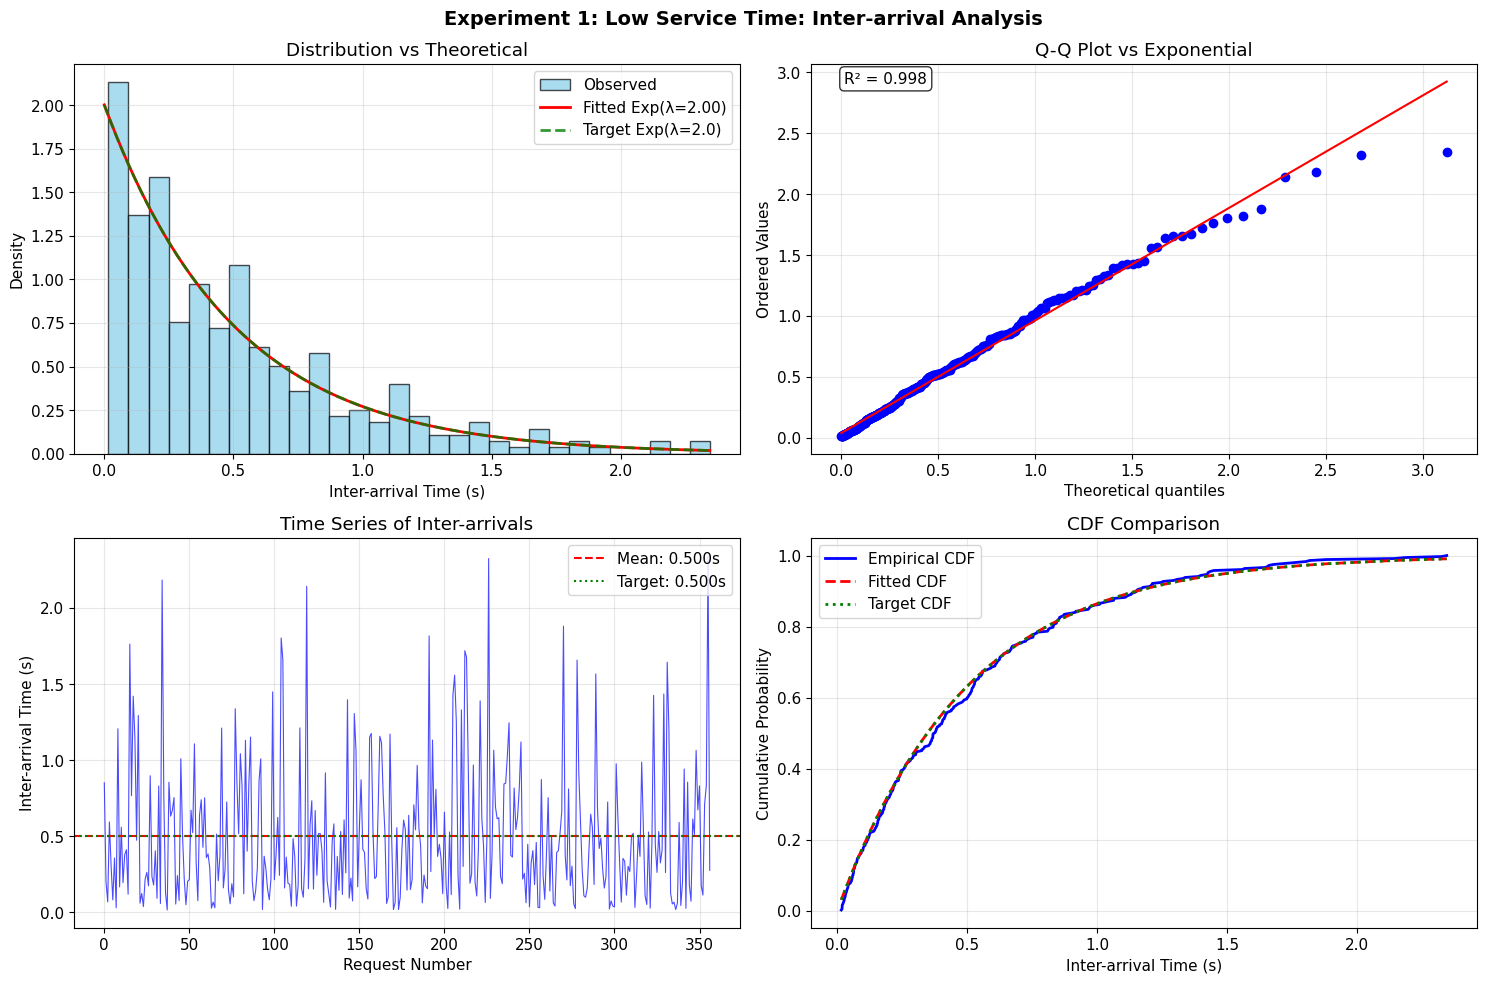


📊 Key Statistics:
   • Sample size: 357
   • Mean inter-arrival: 0.500s
   • Theoretical mean (1/λ): 0.500s
   • Coefficient of variation: 0.912
   • KS test p-value: 0.4967
   • Appears exponential: True

🎯 Interpretation:
✅ SUCCESS: Inter-arrival times appear exponentially distributed
✅ The synchronous client preserves Poisson arrival pattern
✅ Server service time is negligible compared to think time


In [11]:
# Analyze Experiment 1 Results
print("📈 Analyzing Experiment 1: Inter-arrival Time Distribution")
print("=" * 60)

# Statistical analysis of inter-arrival times
exp1_analysis = analyze_inter_arrival_distribution(exp1_results)

# Create comprehensive visual analysis using our plotting module
plot_single_experiment_analysis(
    workload_results=exp1_results,
    analysis_dict=exp1_analysis,
    experiment_name="Experiment 1: Low Service Time",
    target_lambda=lambda_rate
)

# Print summary statistics
print(f"\n📊 Key Statistics:")
print(f"   • Sample size: {exp1_analysis['sample_size']}")
print(f"   • Mean inter-arrival: {exp1_analysis['mean_inter_arrival']:.3f}s")
print(f"   • Theoretical mean (1/λ): {exp1_analysis['theoretical_mean']:.3f}s")
print(f"   • Coefficient of variation: {exp1_analysis['coefficient_variation']:.3f}")
print(f"   • KS test p-value: {exp1_analysis['ks_pvalue']:.4f}")
print(f"   • Appears exponential: {exp1_analysis['appears_exponential']}")

# Interpretation
print(f"\n🎯 Interpretation:")
if exp1_analysis['appears_exponential']:
    print("✅ SUCCESS: Inter-arrival times appear exponentially distributed")
    print("✅ The synchronous client preserves Poisson arrival pattern")
    print("✅ Server service time is negligible compared to think time")
else:
    print("⚠️  UNEXPECTED: Inter-arrival times don't appear exponential")
    print("⚠️  This suggests server service time is affecting arrival pattern")

---
## Experiment 2: High Service Time (Closed Behavior)

Now we **increase the M/M/1 server service time** to create significant response delays.

**Prediction**: With high service time, each request will block the client for a significant duration, breaking the Poisson arrival pattern and creating closed-workload behavior.

In [4]:
# Before running Experiment 2, we need to reconfigure the M/M/1 server
print("🔧 Reconfiguring M/M/1 Server for High Service Time")
print("=" * 55)
print("")
print("📋 MANUAL STEP REQUIRED:")
print("")
print("1. Edit docker-compose.yml:")
print("   Change SERVICE_TIME_SECONDS from \"0.001\" to \"1.0\"")
print("")
print("2. Restart the M/M/1 server:")
print("   docker-compose restart mm1-server")
print("")
print("3. Verify the change:")
print("   curl http://localhost:8084/ (should take ~1 second)")
print("")
print("⏳ Please complete these steps, then continue with the next cell...")
print("")
print("💡 Expected behavior:")
print("   - Service time: ~1.0s (much higher than 0.001s)")
print("   - Think time: ~0.33s (same as before)")
print("   - Now service time > think time → closed workload behavior")

🔧 Reconfiguring M/M/1 Server for High Service Time

📋 MANUAL STEP REQUIRED:

1. Edit docker-compose.yml:
   Change SERVICE_TIME_SECONDS from "0.001" to "1.0"

2. Restart the M/M/1 server:
   docker-compose restart mm1-server

3. Verify the change:
   curl http://localhost:8084/ (should take ~1 second)

⏳ Please complete these steps, then continue with the next cell...

💡 Expected behavior:
   - Service time: ~1.0s (much higher than 0.001s)
   - Think time: ~0.33s (same as before)
   - Now service time > think time → closed workload behavior


In [12]:
# Verify server reconfiguration
print("🔍 Verifying Server Reconfiguration")
print("=" * 40)

# Test response time
import requests
start_test = time.time()
try:
    response = requests.get("http://localhost:8084/", timeout=300)
    response_time = time.time() - start_test
    print(f"✅ Server responds in {response_time:.3f}s")
    
    if response_time > 0.8:
        print("✅ High service time confirmed - ready for Experiment 2")
        ready_for_exp2 = True
    else:
        print("⚠️  Service time still low - please check server configuration")
        ready_for_exp2 = False
        
except Exception as e:
    print(f"❌ Server error: {e}")
    ready_for_exp2 = False

if ready_for_exp2:
    print("\nReady for Experiment 2!")
else:
    print("\n❌ Please reconfigure server before proceeding")

🔍 Verifying Server Reconfiguration
✅ Server responds in 4.904s
✅ High service time confirmed - ready for Experiment 2

Ready for Experiment 2!


In [6]:
# Experiment 2: High Service Time
if 'ready_for_exp2' in locals() and ready_for_exp2:
    print("🚀 Experiment 2: High Service Time (Closed Behavior)")
    print("=" * 50)
    
    # Same parameters as Experiment 1 for comparison
    lambda_rate = 2.0
    duration = 180.0
    
    print(f"Target arrival rate: {lambda_rate} req/s (same as Exp 1)")
    print(f"Expected think time: {1/lambda_rate:.3f}s (exponential mean)")
    print(f"Server service time: ~5.0s (HIGH)")
    print(f"Experiment duration: {duration}s")
    
    print("\n⚠️  Service time > think time → expect closed workload behavior")
    
    # Run the experiment
    print("\nStarting Experiment 2...")
    
    generator = SimpleWorkloadGenerator()
    collector = PrometheusCollector()
    
    start_time = time.time()
    
    exp2_results = generator.generate_workload(
        lambda_rate=lambda_rate,
        duration=duration,
        verbose=True
    )
    
    end_time = time.time()
    
    # Collect metrics
    print("\nCollecting server metrics...")
    exp2_metrics = collector.get_metrics_for_timerange(
        start_time=start_time,
        end_time=end_time,
        metrics=['throughput', 'response_time_avg', 'response_time_95p', 'cpu_usage'],
        step="5s"
    )
    
    generator.close()
    collector.close()
    
    print(f"\n✅ Experiment 2 completed!")
    print(f"   Generated {exp2_results.total_requests} requests")
    print(f"   Actual rate: {exp2_results.actual_rate:.2f} req/s")
    print(f"   Success rate: {exp2_results.success_rate:.1%}")
    
    # Notice: Actual rate should be much lower than target rate!
    rate_reduction = (lambda_rate - exp2_results.actual_rate) / lambda_rate * 100
    print(f"   Rate reduction: {rate_reduction:.1f}% (due to service time blocking)")
    
else:
    print("❌ Skipping Experiment 2 - server not properly configured")

🚀 Experiment 2: High Service Time (Closed Behavior)
Target arrival rate: 2.0 req/s (same as Exp 1)
Expected think time: 0.500s (exponential mean)
Server service time: ~5.0s (HIGH)
Experiment duration: 180.0s

⚠️  Service time > think time → expect closed workload behavior

Starting Experiment 2...
Starting workload generation:
  Target rate: 2.0 req/s
  Duration: 180.0 seconds
  URL: http://localhost:8084/

Workload completed:
  Total requests: 34
  Actual rate: 0.18 req/s
  Success rate: 100.00%
  Inter-arrival times collected: 33


✅ Experiment 2 completed!
   Generated 34 requests
   Actual rate: 0.18 req/s
   Success rate: 100.0%
   Rate reduction: 90.8% (due to service time blocking)


Analyzing Experiment 2: High Service Time Effects


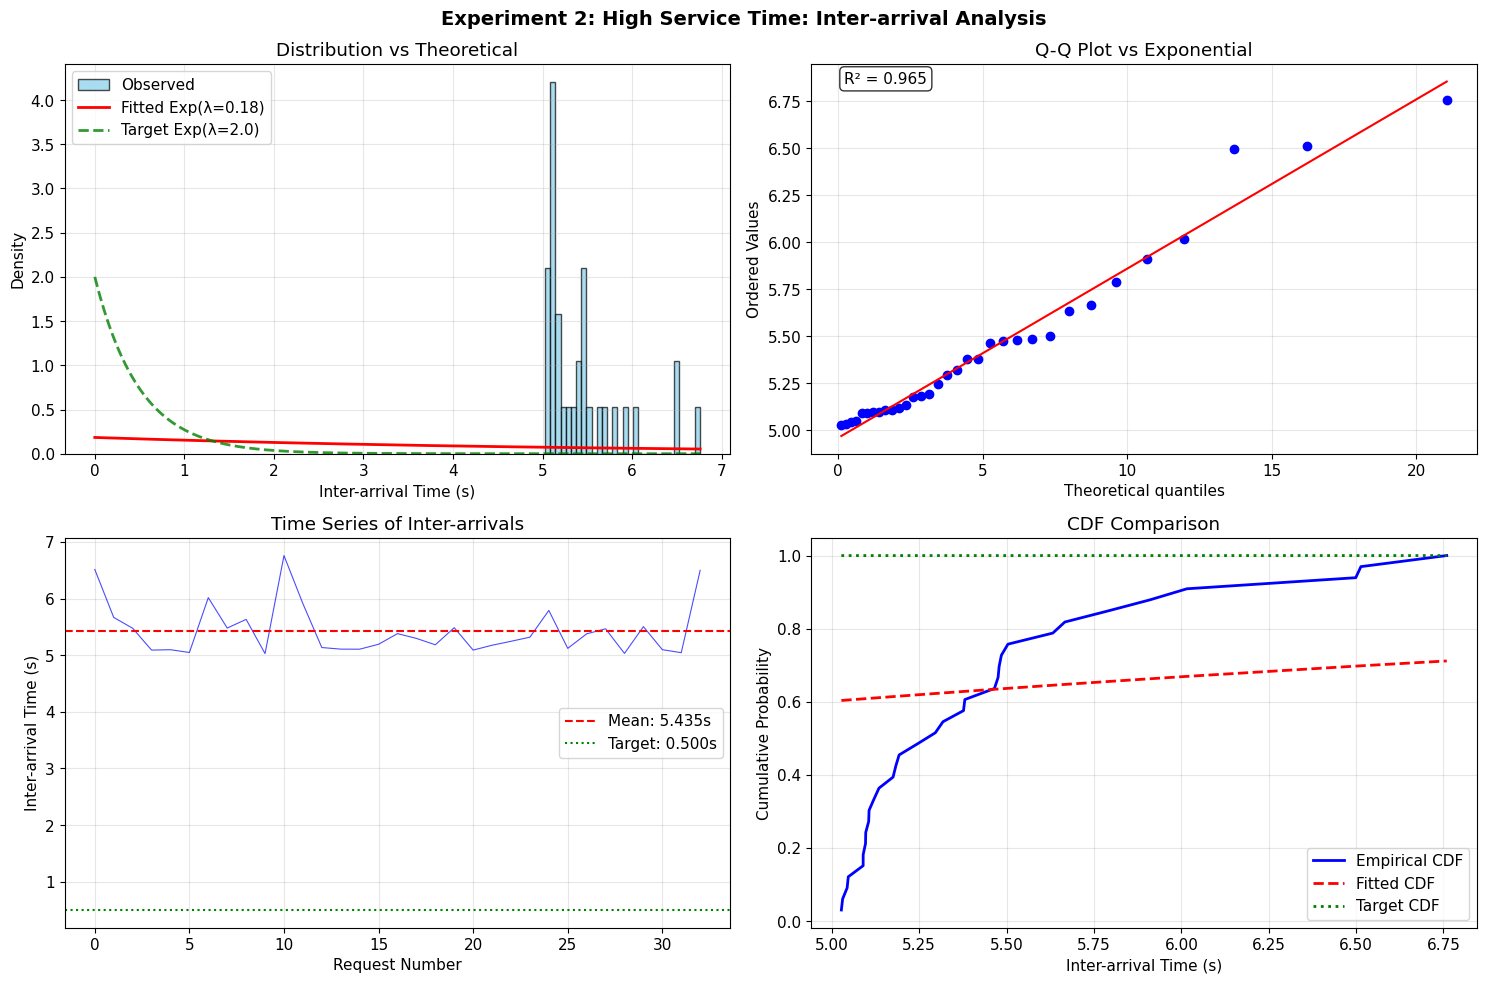


Key Statistics:
   • Sample size: 33
   • Mean inter-arrival: 5.435s
   • Theoretical mean (1/λ): 0.500s
   • Coefficient of variation: 0.082
   • KS test p-value: 0.0000
   • Appears exponential: False

Comparison with Experiment 1:
   • CV - Exp 2 (High Service): 0.082
   • Rate - Exp 2: 0.18 req/s

Interpretation:
SUCCESS: High service time broke the exponential pattern
This demonstrates closed workload behavior
Service time now dominates over think time
Throughput reduction: 90.8% due to service time blocking


In [7]:
# Analyze Experiment 2 Results
if 'exp2_results' in locals():
    print("Analyzing Experiment 2: High Service Time Effects")
    print("=" * 55)
    
    # Statistical analysis of Experiment 2
    exp2_analysis = analyze_inter_arrival_distribution(exp2_results)
    
    # Create comprehensive visual analysis using our plotting module
    plot_single_experiment_analysis(
        workload_results=exp2_results,
        analysis_dict=exp2_analysis,
        experiment_name="Experiment 2: High Service Time",
        target_lambda=lambda_rate
    )
    
    # Print summary statistics
    print(f"\nKey Statistics:")
    print(f"   • Sample size: {exp2_analysis['sample_size']}")
    print(f"   • Mean inter-arrival: {exp2_analysis['mean_inter_arrival']:.3f}s")
    print(f"   • Theoretical mean (1/λ): {exp2_analysis['theoretical_mean']:.3f}s")
    print(f"   • Coefficient of variation: {exp2_analysis['coefficient_variation']:.3f}")
    print(f"   • KS test p-value: {exp2_analysis['ks_pvalue']:.4f}")
    print(f"   • Appears exponential: {exp2_analysis['appears_exponential']}")
    
    # Compare with Experiment 1
    print(f"\nComparison with Experiment 1:")
    print(f"   • CV - Exp 2 (High Service): {exp2_analysis['coefficient_variation']:.3f}")
    print(f"   • Rate - Exp 2: {exp2_results.actual_rate:.2f} req/s")
    
    # Interpretation
    print(f"\nInterpretation:")
    if not exp2_analysis['appears_exponential']:
        print("SUCCESS: High service time broke the exponential pattern")
        print("This demonstrates closed workload behavior")
        print("Service time now dominates over think time")
    else:
        print("UNEXPECTED: Pattern still appears exponential")
        print("Service time might not be high enough relative to think time")
    
    rate_reduction = (lambda_rate - exp2_results.actual_rate) / lambda_rate * 100
    print(f"Throughput reduction: {rate_reduction:.1f}% due to service time blocking")
    
else:
    print("Cannot analyze - Experiment 2 was not completed")

---
## Experiment 3: Asynchronous Workload (True Open Behavior)

Now we demonstrate **true open workload behavior** using an asynchronous workload generator.

**Key insight**: Even with high service time (1.0s), an async generator should preserve the Poisson arrival pattern because requests are scheduled **independently** of response times.

**Prediction**: Inter-arrival times will remain exponential regardless of server service time, proving that true open workloads are independent of system performance.

In [13]:
# Experiment 3: Asynchronous Workload Generator
print("🚀 Experiment 3: Asynchronous Workload (True Open Behavior)")
print("=" * 60)

# Same parameters as previous experiments for direct comparison
lambda_rate = 2.0
duration = 180.0  # Shorter duration since async is more efficient

print(f"Target arrival rate: {lambda_rate} req/s (same as previous)")
print(f"Expected think time: {1/lambda_rate:.3f}s (exponential mean)")
print(f"Server service time: ~1.0s (HIGH - same as Exp 2)")
print(f"Experiment duration: {duration}s")

print("\n🔑 KEY DIFFERENCE: Requests scheduled independently of response time")
print("📈 PREDICTION: Should maintain exponential inter-arrivals despite high service time")

# Run async experiment
print("\n📊 Starting asynchronous workload generation...")

async def run_experiment_3():
    async_generator = AsyncWorkloadGenerator()
    collector = PrometheusCollector()
    
    start_time = time.time()
    
    # Generate async workload
    exp3_results = await async_generator.generate_workload(
        lambda_rate=lambda_rate,
        duration=duration,
        verbose=True
    )
    
    end_time = time.time()
    
    # Collect metrics
    print("\nCollecting server metrics...")
    exp3_metrics = collector.get_metrics_for_timerange(
        start_time=start_time,
        end_time=end_time,
        metrics=['throughput', 'response_time_avg', 'response_time_95p', 'cpu_usage'],
        step="5s"
    )
    
    collector.close()
    return exp3_results, exp3_metrics

# Run the async experiment
exp3_results, exp3_metrics = await run_experiment_3()

print(f"\n✅ Experiment 3 completed!")
print(f"   Generated {exp3_results.total_requests} requests")
print(f"   Actual rate: {exp3_results.actual_rate:.2f} req/s")
print(f"   Success rate: {exp3_results.success_rate:.1%}")

# Compare with sync high service experiment
if 'exp2_results' in locals():
    throughput_improvement = (exp3_results.actual_rate / exp2_results.actual_rate) * 100
    print(f"   Throughput vs Sync High: {throughput_improvement:.1f}% (async advantage)")

print(f"   Inter-arrival measurements: {len(exp3_results.inter_arrival_times)}")

🚀 Experiment 3: Asynchronous Workload (True Open Behavior)
Target arrival rate: 2.0 req/s (same as previous)
Expected think time: 0.500s (exponential mean)
Server service time: ~1.0s (HIGH - same as Exp 2)
Experiment duration: 180.0s

🔑 KEY DIFFERENCE: Requests scheduled independently of response time
📈 PREDICTION: Should maintain exponential inter-arrivals despite high service time

📊 Starting asynchronous workload generation...
Starting ASYNC workload generation:
  Target rate: 2.0 req/s
  Duration: 180.0 seconds
  URL: http://localhost:8084/
  Scheduled 348 requests
  Scheduled 50 requests, rate: 1.90 req/s
  Scheduled 100 requests, rate: 1.74 req/s
  Scheduled 150 requests, rate: 1.56 req/s
  Scheduled 200 requests, rate: 1.70 req/s
  Scheduled 250 requests, rate: 1.86 req/s
  Scheduled 300 requests, rate: 1.91 req/s
  Waiting for all requests to complete...

Async workload completed:
  Total requests: 348
  Actual rate: 1.79 req/s
  Success rate: 0.86%
  Inter-arrival times: 347



📈 Analyzing Experiment 3: Asynchronous Workload Behavior


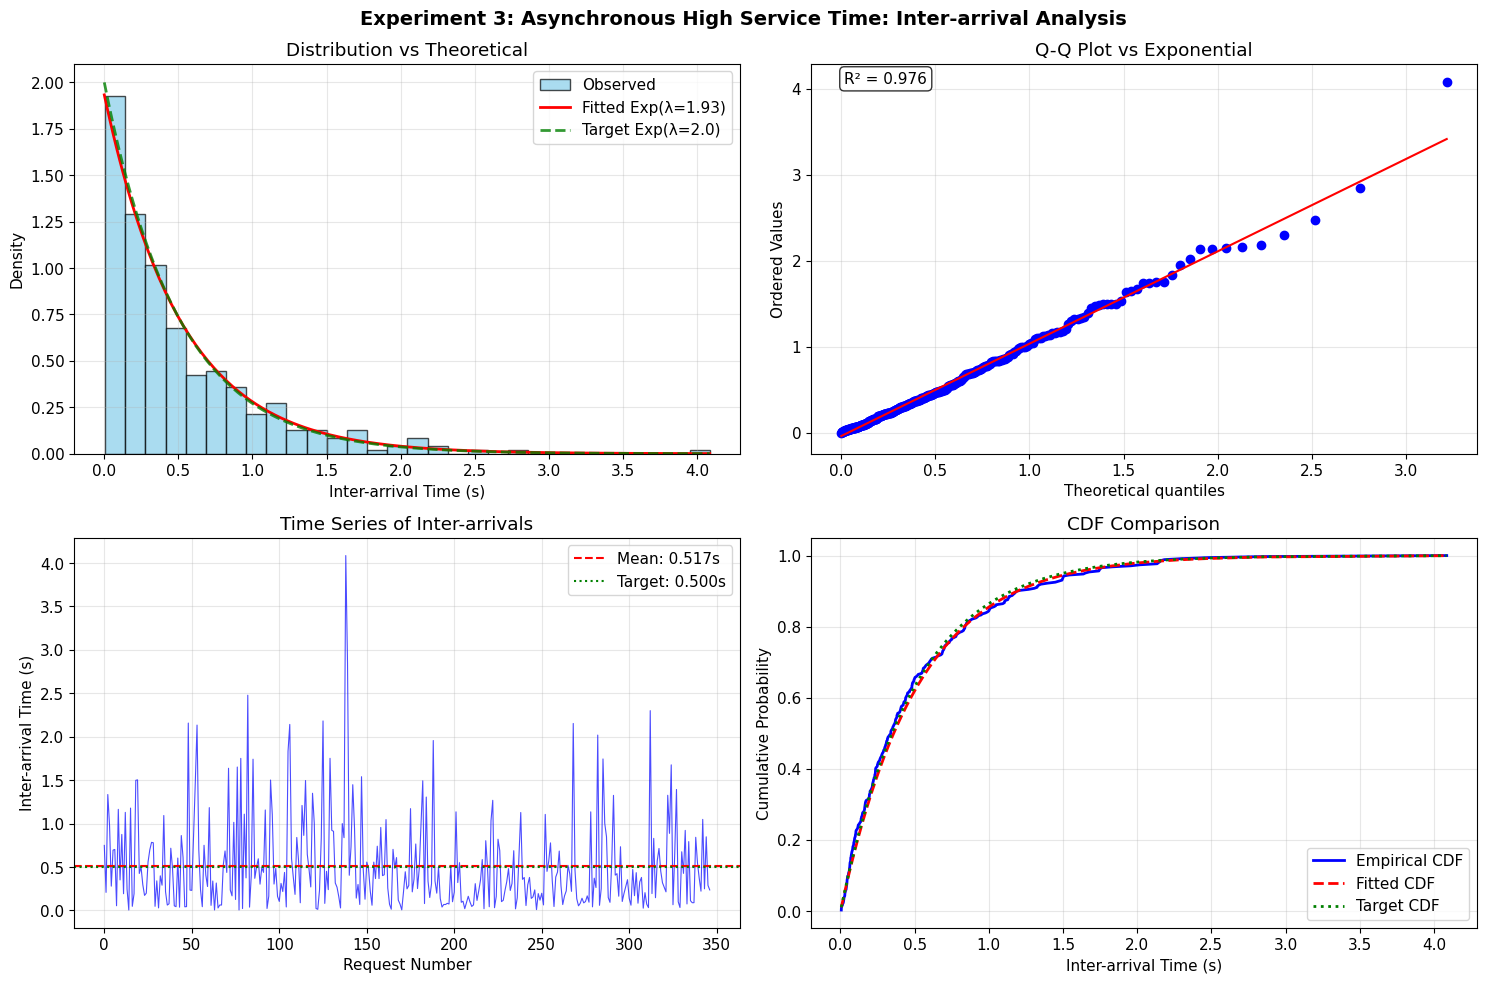


📊 Key Statistics:
   • Sample size: 347
   • Mean inter-arrival: 0.517s
   • Theoretical mean (1/λ): 0.500s
   • Coefficient of variation: 1.059
   • KS test p-value: 0.5475
   • Appears exponential: True

🔄 Comparison with Previous Experiments:
   • CV - Exp 1 (Sync Low): 0.912
   • CV - Exp 2 (Sync High): 0.082
   • CV - Exp 3 (Async High): 1.059

🎯 Interpretation:
✅ SUCCESS: Async workload maintains exponential inter-arrival distribution
✅ True open workload behavior confirmed despite high service time
✅ Request scheduling independent of server response time
✅ Throughput advantage over sync: 9.7x improvement
🔬 PROOF: Service time does not affect Poisson arrival patterns

💡 Key Insight:
   This experiment demonstrates that TRUE open workload behavior
   requires asynchronous request generation. Synchronous clients
   inevitably create closed workload effects when service times
   become significant relative to think times.


In [14]:
# Analyze Experiment 3 Results
if 'exp3_results' in locals():
    print("📈 Analyzing Experiment 3: Asynchronous Workload Behavior")
    print("=" * 60)
    
    # Statistical analysis of inter-arrival times
    exp3_analysis = analyze_inter_arrival_distribution(exp3_results)
    
    # Create comprehensive visual analysis using our plotting module
    plot_single_experiment_analysis(
        workload_results=exp3_results,
        analysis_dict=exp3_analysis,
        experiment_name="Experiment 3: Asynchronous High Service Time",
        target_lambda=lambda_rate
    )
    
    # Print summary statistics
    print(f"\n📊 Key Statistics:")
    print(f"   • Sample size: {exp3_analysis['sample_size']}")
    print(f"   • Mean inter-arrival: {exp3_analysis['mean_inter_arrival']:.3f}s")
    print(f"   • Theoretical mean (1/λ): {exp3_analysis['theoretical_mean']:.3f}s")
    print(f"   • Coefficient of variation: {exp3_analysis['coefficient_variation']:.3f}")
    print(f"   • KS test p-value: {exp3_analysis['ks_pvalue']:.4f}")
    print(f"   • Appears exponential: {exp3_analysis['appears_exponential']}")
    
    # Compare with previous experiments
    print(f"\n🔄 Comparison with Previous Experiments:")
    if 'exp1_analysis' in locals():
        print(f"   • CV - Exp 1 (Sync Low): {exp1_analysis['coefficient_variation']:.3f}")
    if 'exp2_analysis' in locals():
        print(f"   • CV - Exp 2 (Sync High): {exp2_analysis['coefficient_variation']:.3f}")
    print(f"   • CV - Exp 3 (Async High): {exp3_analysis['coefficient_variation']:.3f}")
    
    # Interpretation specific to async behavior
    print(f"\n🎯 Interpretation:")
    if exp3_analysis['appears_exponential']:
        print("✅ SUCCESS: Async workload maintains exponential inter-arrival distribution")
        print("✅ True open workload behavior confirmed despite high service time")
        print("✅ Request scheduling independent of server response time")
        
        if 'exp2_analysis' in locals():
            throughput_ratio = exp3_results.actual_rate / exp2_results.actual_rate
            print(f"✅ Throughput advantage over sync: {throughput_ratio:.1f}x improvement")
            
        print("🔬 PROOF: Service time does not affect Poisson arrival patterns")
    else:
        print("⚠️  UNEXPECTED: Async workload shows non-exponential pattern")
        print("⚠️  This suggests implementation issues or system constraints")
        
    # Key insight about async vs sync
    print(f"\n💡 Key Insight:")
    print(f"   This experiment demonstrates that TRUE open workload behavior")
    print(f"   requires asynchronous request generation. Synchronous clients")
    print(f"   inevitably create closed workload effects when service times")
    print(f"   become significant relative to think times.")
    
else:
    print("❌ Cannot analyze - Experiment 3 was not completed")